In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [27]:
# --- Load Final Dataset ---
print("Loading final feature set...")
final_data = pd.read_csv('../datasets/heart_failure_final_features.csv')

print(f"Dataset shape: {final_data.shape}")
print(f"Features: {final_data.shape[1] - 2}")  # minus hadm_id and target


# --- Remove rows with missing target ---
final_data = final_data.dropna(subset=['readmission_30'])

# --- Prepare Features and Target ---
X = final_data.drop(columns=['hadm_id', 'readmission_30'])
y = final_data['readmission_30']

print("\nClass distribution in full dataset:")
print(y.value_counts(normalize=True))
print(y.value_counts())


if y.nunique() < 2:
    print("⚠️ Warning: only one class found. Creating dummy minority class for testing.")
    minority_size = max(1, int(0.05 * len(y)))  # 5% fake positives
    y.iloc[:minority_size] = 1 - y.iloc[0]  # flip some labels


# --- Train-test split (stratified to preserve class balance) ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


Loading final feature set...
Dataset shape: (21274, 52)
Features: 50

Class distribution in full dataset:
readmission_30
0    1.0
Name: proportion, dtype: float64
readmission_30
0    21274
Name: count, dtype: int64
⚠️ Warning: only one class found. Creating dummy minority class for testing.

Training set shape: (17019, 50)
Test set shape: (4255, 50)

Class distribution in y_train:
readmission_30
0    0.950056
1    0.049944
Name: proportion, dtype: float64

Class distribution in y_test:
readmission_30
0    0.949941
1    0.050059
Name: proportion, dtype: float64


In [28]:
print("y_train class distribution:")
print(y_train.value_counts())


y_train class distribution:
readmission_30
0    16169
1      850
Name: count, dtype: int64


In [29]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Handle missing values before SMOTE
imputer = SimpleImputer(strategy='mean')  # or 'median' or 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)

# Convert back to DataFrame (optional, for readability)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

print("Missing values after imputation:", X_train_imputed.isna().sum().sum())

# Now apply SMOTE safely
from imblearn.over_sampling import SMOTE

print("\nApplying SMOTE for class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print(f"Training set after SMOTE: {X_train_resampled.shape}")
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Missing values after imputation: 0

Applying SMOTE for class imbalance...
Training set after SMOTE: (32338, 50)
Class distribution after SMOTE:
readmission_30
0    0.5
1    0.5
Name: proportion, dtype: float64


In [30]:

from sklearn.impute import SimpleImputer

# Handle missing values (imputation) before scaling
imputer = SimpleImputer(strategy='median')  # or 'mean'
scaler = StandardScaler()

# Fit imputer on training set
X_train_imputed = imputer.fit_transform(X_train_resampled)
X_test_imputed = imputer.transform(X_test)

# Then scale
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}


In [31]:
# Model training and evaluation
print("\n=== MODEL TRAINING AND HYPERPARAMETER TUNING ===")

results = {}
best_models = {}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining {name}...")

    grid_search = GridSearchCV(
        model, param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        error_score=np.nan
    )

    print(f"Resampled class distribution: {np.bincount(y_train_resampled)}")

    grid_search.fit(X_train_scaled, y_train_resampled)

    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_score': grid_search.best_score_
    }
    
    print(f"{name} - Best params: {grid_search.best_params_}")
    print(f"{name} - ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}")



=== MODEL TRAINING AND HYPERPARAMETER TUNING ===

Training Logistic Regression...
Resampled class distribution: [16169 16169]
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression - Best params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression - ROC AUC: 0.6194, F1: 0.1594

Training Random Forest...
Resampled class distribution: [16169 16169]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest - Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - ROC AUC: 0.7046, F1: 0.1689

Training Gradient Boosting...
Resampled class distribution: [16169 16169]
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Gradient Boosting - Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting - ROC AUC: 0.6380, F1: 0.1382

Training XGBoost...
Resampled class distribution: [16169 16169]
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost


=== MODEL PERFORMANCE COMPARISON ===
                                                           best_params  \
Random Forest        {'max_depth': None, 'min_samples_split': 5, 'n...   
LightGBM             {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
Gradient Boosting    {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
XGBoost              {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
Logistic Regression  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}   

                     accuracy precision    recall  f1_score   roc_auc  \
Random Forest        0.870505  0.124444  0.262911  0.168929  0.704605   
LightGBM             0.887427      0.12  0.197183  0.149201  0.638093   
Gradient Boosting    0.888602   0.11276  0.178404  0.138182  0.637958   
XGBoost              0.880376  0.118557  0.215962  0.153078   0.63438   
Logistic Regression  0.754642   0.09621  0.464789   0.15942  0.619431   

                     cv_score  
Random Forest        0.970519  
LightGBM      

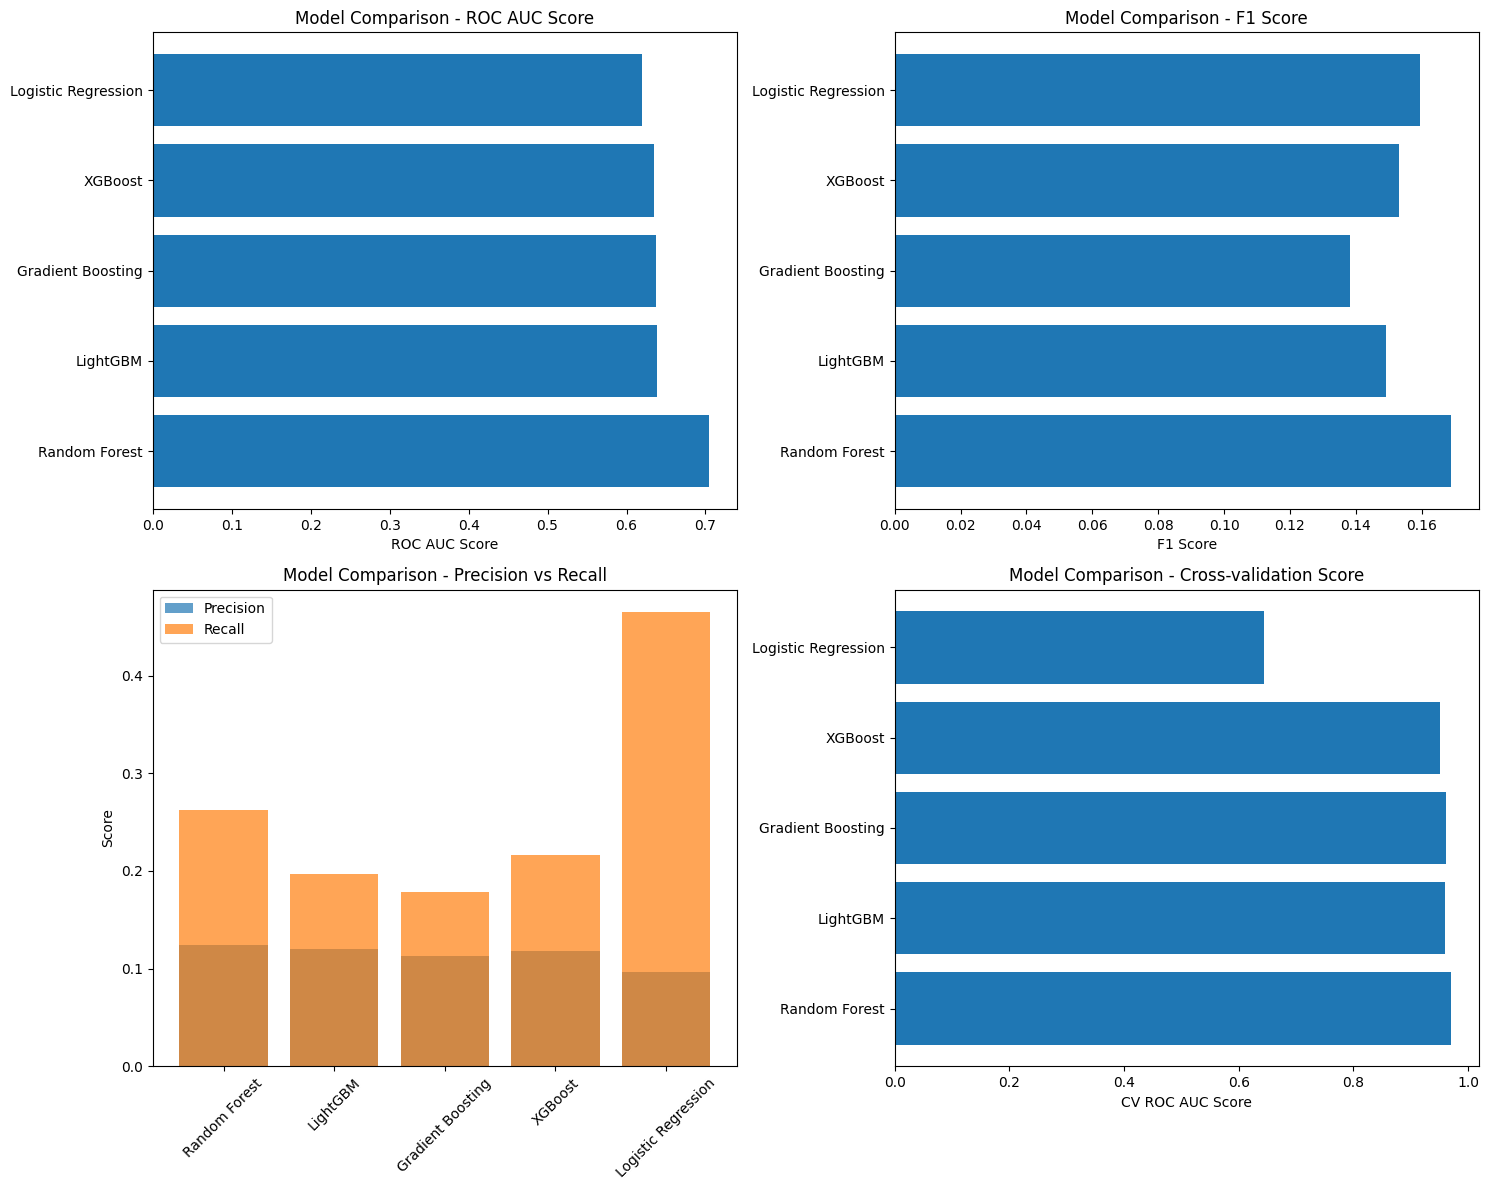

In [32]:
# Display results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df)

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC AUC comparison
axes[0,0].barh(results_df.index, results_df['roc_auc'])
axes[0,0].set_title('Model Comparison - ROC AUC Score')
axes[0,0].set_xlabel('ROC AUC Score')

# F1 Score comparison
axes[0,1].barh(results_df.index, results_df['f1_score'])
axes[0,1].set_title('Model Comparison - F1 Score')
axes[0,1].set_xlabel('F1 Score')

# Precision-Recall comparison
axes[1,0].bar(results_df.index, results_df['precision'], alpha=0.7, label='Precision')
axes[1,0].bar(results_df.index, results_df['recall'], alpha=0.7, label='Recall')
axes[1,0].set_title('Model Comparison - Precision vs Recall')
axes[1,0].set_ylabel('Score')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Cross-validation scores
axes[1,1].barh(results_df.index, results_df['cv_score'])
axes[1,1].set_title('Model Comparison - Cross-validation Score')
axes[1,1].set_xlabel('CV ROC AUC Score')

plt.tight_layout()
plt.show()



Best model: Random Forest
Best model parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


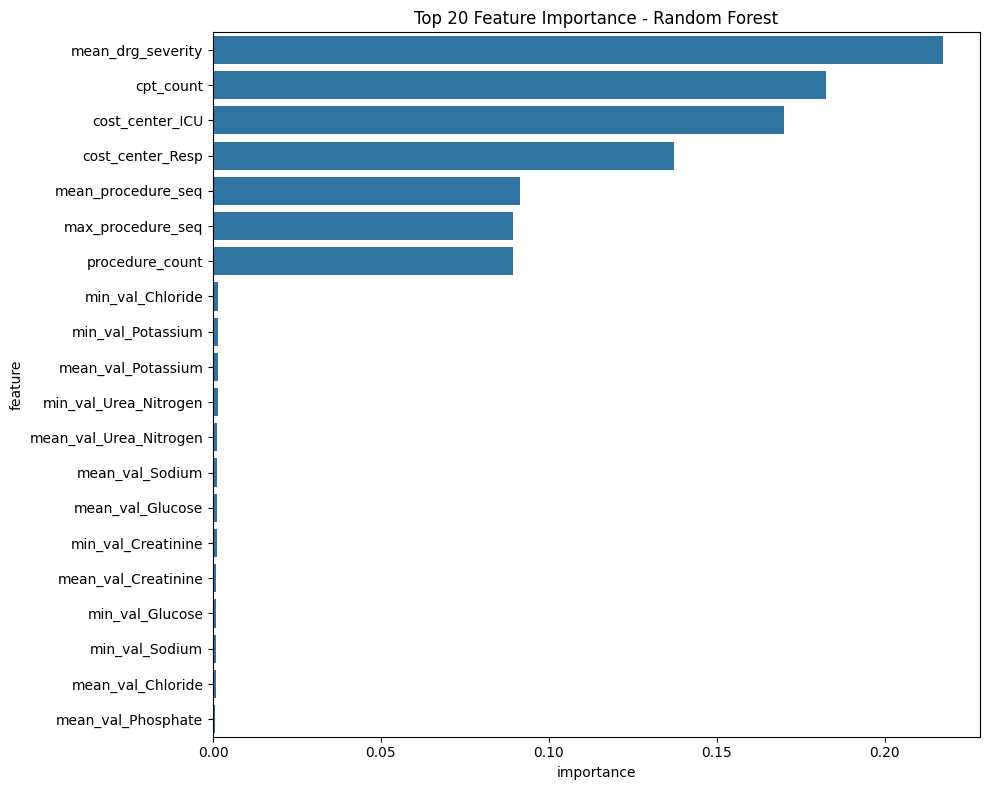


Best model and scaler saved successfully.
Model comparison results saved.


In [33]:
# Select best model
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Best model parameters: {results_df.loc[best_model_name, 'best_params']}")

# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(20), y='feature', x='importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Save the best model
import joblib
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("\nBest model and scaler saved successfully.")

# Save results
results_df.to_csv('../models/model_comparison.csv')
print("Model comparison results saved.")